## Class 9 Agenda:
  * **Null accuracy**
  * **Confusion matrix**
  * **sensitivity, specificity, accuracy**
  * **ROC curves, AUC, setting a threshold**
  * **ROC curves, AUC: All that matters is that ordering is preserved**

Today we are going to talk about how to more accurately measure models for supervised classification. Because supervised classification problems are ubiquitous (will this person churn? will this ad be clicked? will this stock go up tomorrow?), being able to evaluate how well a supervised classifier works and to be able to choose what defines a "well-performing" classifier is very important.

To that end, we will also learn how to:
  * decompose the kinds of errors a trained model makes (on unseen data)
  * decide where (at what probability) to threshold a binary classifier (one that decides between two choices) given what is acceptable in terms of the kinds of errors the model is expected to make in the wild. 
  * understand confusion matrices
  
** By the end of this notebook you will:**

- Have a working conceptual understanding of key aspects of model evaluation in machine learning
- Be able to interpret key model metrics computed using scikit-learn
- Be able to to use different model metrics for model evaluation, depending on the goals of your model
- Be able to explain what an ROC curve and AUC metric are and how they should be used when evaluating classifiers and setting classifier thresholds.

Let's import everything we're going to use today, like always:

In [2]:
#data handling, model creation/evaluation
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn import metrics
import scipy.stats as stats

# visualization
%matplotlib inline
import seaborn as sns

### Null Accuracy

Null accuracy measures what our expected accuracy should be if we were to **use the most frequent response (most frequent class) as our prediction for every new sample we see.** It is a baseline against which you may want to measure your classifier, especially when your classes are really unbalanced.

In class 5, when we learned about [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression), we attempted to build a predictive model on a dataset that was fairly unbalanced (the vertebral column dataset from UCI).

Let's use that dataset again to measure null accuracy, and see whether a basic Logistic Regression model can give higher test set accuracy than this:

In [40]:
vertebral_data = pd.read_csv("./data/vertebral_column_2_categories.dat",sep=" ", 
                             names=["pelvic_incidence","pelvic_tilt","lumbar_lordosis_angle",
                                    "sacral_slope","pelvic_radius","spondy_grade","outcome"])
vertebral_data.outcome.value_counts()
vertebral_data.outcome = (vertebral_data.outcome =="AB").astype(int)
X = vertebral_data[vertebral_data.columns.tolist()[:-1]]
y = vertebral_data.outcome

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

lr = LogisticRegression(C=1e9,solver="lbfgs")
lr.fit(X_train,y_train)
y_test_pred = lr.predict(X_test)

print("Test set accuracy of LR model: ",metrics.accuracy_score(y_test, y_test_pred))

Test set accuracy of LR model:  0.8709677419354839


**What is the null accuracy here?**

It is simply the fraction of `AB` (class 1) samples in the test set (since that is the most frequent class in the whole dataset):

In [41]:
# compute null accuracy manually
print("Null accuracy on the test set: ",y_test.mean())

Null accuracy on the test set:  0.7096774193548387


We can compute this using the scikit-learn api by creating what's called a `DummyClassifier`.

It can create a variety of dummy models based on simple statistics it is trained on.

We are going to create one where the model simply predicts the most frequent class, by passing in a `string` to the `strategy` parameter when we generate the unfitted model: 

In [42]:
from sklearn.dummy import DummyClassifier
dumb_model = DummyClassifier(strategy='most_frequent')
dumb_model.fit(X_train, y_train)
y_dumb_class = dumb_model.predict(X_test)
print("Most frequent class dummy classifier test accuracy: ",metrics.accuracy_score(y_test, y_dumb_class))

Most frequent class dummy classifier test accuracy:  0.7096774193548387


#### Exercise Time

* Use the same dummy classifier approach and train an LR model using 10-fold cross validation and compute the accuracy score of each model.
* Do the same with 30-fold cross validation and plot both test-set accuracy distributions. Are the two distributions overlapping? If they aren't what does that mean?

In [59]:
cross_val_score(dumb_model,X,y,cv=10).mean()

0.6774193548387097

In [15]:
cross_val_score(lr,X,y,cv=10).mean()

0.8290322580645162

/Users/Nicole/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/Nicole/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


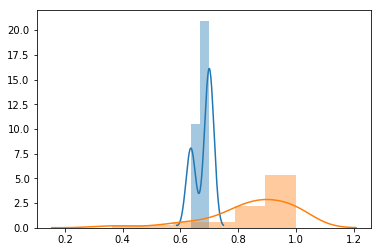

In [61]:
sns.distplot(cross_val_score(dumb_model,X,y,cv=30))
sns.distplot(cross_val_score(lr,X,y,cv=30))

### Confusion Matrix

In order to more fully understand the kinds of mistakes the model is making, we need to investigate what is called the **confusion matrix** of the model on unseen (test) data. The confusion matrix simply counts the number of predictions that fall into each possible prediction bucket.

So, for a 2-class classification problem, there are 4 "prediction buckets":
  * predict 0 (normal), actual 0 (normal) - called a **correct rejection/true negative**
  * predict 0 (normal), actual 1 (abnormal) <-- this is an error called a **miss/false negative**
  * predict 1 (abnormal), actual 0 (normal) <-- this is an error called a **false alarm/false positive**
  * predict 1 (abnormal), actual 1 (abnormal) - called a **hit/true positive**
  
![confusion matrix](./images/confusion_matrix.png)

Let's compute the confusion matrix on the test set for our Logistic Regression model:

In [46]:
# confusion matrix
cm = metrics.confusion_matrix(y_test, y_test_pred)
cm

array([[21,  6],
       [ 6, 60]])

By convention in a confusion matrix, the actual categories are the rows and the predicted values are the columns. Our confusion matrix shows that on the test set we have an equal number of misses and false alarms (both values are 6).

We can break down the confusion matrix into a variety of single-value metrics that answer specific questions about how our model is expected to fare on new data:

  * **sensitivity/true positive rate(TPR)/recall:** What fraction of the "abnormal" samples in unseen data did we correctly predict? 
  $$ TPR = \frac {\sum TP}{\sum (TP+FN)}$$
  * **specificity/true negative rate(TNR):** What fraction of "normal" samples in unseen data did we correctly predict?  
  $$ TNR = \frac {\sum TN}{\sum (TN+FP)}$$
  * **precision/positive predictive value(PPV)** How frequently is our model correct when it predicts "abnormal" on new data?
  $$ PPV = \frac {\sum TP}{\sum (TP+FP)}$$
  * **negative predictive value (NPV):** How frequently is our model correct when it predicts "normal" on new data? 
  $$ NPV = \frac {\sum TN}{\sum (TN+FN)}$$
  * **accuracy (ACC):** How frequently is our model correct on all new data, regardless of class?
  $$ ACC = \frac {\sum (TN+TP)}{\sum (TN+FN+TP+FP)}$$
  * **F1 score (F1): ** The harmonic mean of precision and recall:
  $$ F1 = 2*\frac {Precision*Recall}{Precision+Recall}$$

In [47]:
# calculate each metric by hand
print("Sensitivity/Recall (TPR): ",cm[1,1] / float(cm[1,1] + cm[1,0]))
print("Specificity (TNR): ", cm[0,0] / float(cm[0,0] + cm[0,1]))
print("Precision (PPV): ", cm[1,1] / float(cm[1,1]+cm[0,1]))
print("NPV: ", cm[0,0] / float(cm[0,0]+cm[1,0]))
print("Accuracy: ", (cm[1,1]+cm[0,0]) / float(cm.sum()))
print("F1:", metrics.f1_score(y_test,y_test_pred))

Sensitivity/Recall (TPR):  0.9090909090909091
Specificity (TNR):  0.7777777777777778
Precision (PPV):  0.9090909090909091
NPV:  0.7777777777777778
Accuracy:  0.8709677419354839
F1: 0.9090909090909091


In [48]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(y_test,y_test_pred))
print("Precision (PPV): ", metrics.precision_score(y_test,y_test_pred))
print("Accuracy: ", metrics.accuracy_score(y_test,y_test_pred))
print("F1:", metrics.f1_score(y_test,y_test_pred))

Sensitivity/Recall (TPR):  0.9090909090909091
Precision (PPV):  0.9090909090909091
Accuracy:  0.8709677419354839
F1: 0.9090909090909091


Or we can compute the full classification report, which will give us precision/recall per-feature:

In [49]:
print("Classification Report:\n", metrics.classification_report(y_test,y_test_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.78      0.78        27
           1       0.91      0.91      0.91        66

   micro avg       0.87      0.87      0.87        93
   macro avg       0.84      0.84      0.84        93
weighted avg       0.87      0.87      0.87        93



### ROC Curves and AUC

So far, we've working with the thresholded decisions a given classifier/model makes when it outputs a prediction (all we've been looking at is the predicted category of trained models). 

However, many classifiers (including both **logistic regression** and **random forest** models) can output a "confidence" associated with their prediction (this is called a **prediction probability**). 

Let's take a look at the prediction probabilites and the predictions of our original logistic regression classifier on our single test set:

In [50]:
#lr probabilities per category for first five samples
predicted_probs_lr = lr.predict_proba(X_test).round(3)
predictions_lr = lr.predict(X_test)

print("Logistic Regression predicted probabilities for first five samples in test set:\n",predicted_probs_lr[:5])
print("Logistic Regression predictions for first five samples in test set:\n",predictions_lr[:5])
y_test_lr_df = pd.DataFrame(
    np.concatenate((
        predicted_probs_lr,predictions_lr.reshape((predictions_lr.shape[0],-1)),
        y_test.values.reshape((y_test.shape[0],-1))),axis=1
    ),
    columns = ["class_0","class_1","predicted","actual"])

y_test_lr_df.head()

Logistic Regression predicted probabilities for first five samples in test set:
 [[0.018 0.982]
 [0.111 0.889]
 [0.011 0.989]
 [0.094 0.906]
 [0.01  0.99 ]]
Logistic Regression predictions for first five samples in test set:
 [1 1 1 1 1]


,class_0,class_1,predicted,actual
0,0.018,0.982,1.0,1.0
1,0.111,0.889,1.0,0.0
2,0.011,0.989,1.0,1.0
3,0.094,0.906,1.0,1.0
4,0.010,0.990,1.0,1.0


Lets generate the same table of predicted probabilities, predictions, and actual values, for a trained random forest classifier that contains 100 trees:

In [51]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train)

predicted_probs_rf = rf.predict_proba(X_test)
predictions_rf = rf.predict(X_test)

y_test_rf_df = pd.DataFrame(
    np.concatenate((
        predicted_probs_rf,predictions_rf.reshape((predictions_rf.shape[0],-1)),
        y_test.values.reshape((y_test.shape[0],-1))),axis=1
    ),
    columns = ["class_0","class_1","predicted","actual"])

y_test_rf_df.head()

,class_0,class_1,predicted,actual
0,0.03,0.97,1.0,1.0
1,0.37,0.63,1.0,0.0
2,0.07,0.93,1.0,1.0
3,0.05,0.95,1.0,1.0
4,0.22,0.78,1.0,1.0


In both of these cases, the prediction threshold (for either class) is set to 0.5, so the class with the probability that is over 0.5 is the predicted class.

**However, 0.5 doesn't necessarily have to be the threshold we use for our classifier's decision threshold!**

For example, we might want to be VERY CERTAIN that the classifier thinks something is class 1 (for example, a likelihood of cancer presence given some test results). 

In that case, we would require that the class 1 probability is > 0.8 (for example). As a result, the ratio of TP/TN/FN/FP would change, yielding a new confusion matrix, with a new set of precision/recall/accuracy estimates.

**In general, the default probability threshold for a given classifier maximizes accuracy, but not the other metrics like precision, recall, etc.**

But, what if we varied the prediction thresholds to obtain different TP/TN/FP/FN values (different confusion matrices) across all possible threshold values for our classifier?

This is exactly what an [ROC (Receiver Operating Characteristic) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) does.

**An ROC Curve is a graphical plot that illustrates the performance of a binary classifier system as its discrimination threshold is systematically varied.**

Let's generate the ROC curves for both of our models:

Text(0,0.5,'True Positive Rate (Sensitivity)')

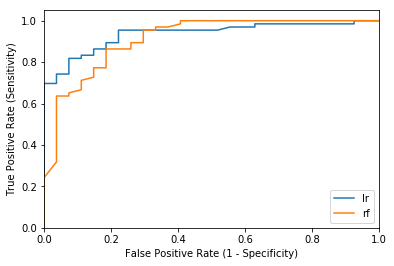

In [52]:
#generate lr model false positive and true positive rates
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_test, predicted_probs_lr[:,1])

#generate same for random forest model
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, predicted_probs_rf[:,1])

# plot LR and RF model ROC curves
sns.mpl.pyplot.plot(fpr_lr, tpr_lr,label="lr")
sns.mpl.pyplot.plot(fpr_rf, tpr_rf,label="rf")
sns.mpl.pyplot.xlim([0, 1])
sns.mpl.pyplot.ylim([0, 1.05])
sns.mpl.pyplot.legend(loc="lower right")
sns.mpl.pyplot.xlabel('False Positive Rate (1 - Specificity)')
sns.mpl.pyplot.ylabel('True Positive Rate (Sensitivity)')

The ROC curve allows you to balance how many FN's (misses) and FP's (false alarms) you're willing to have with respect to one of your classes.

There's a metric that allows you to quantify the overall performance of your binary classifier, regardless of the threshold you choose. This metric is called the **AUC (area under the curve)**, and is a systematic way to compare two classifiers relative to each other, across all decision thresholds. If model A has a higher AUC than model B then this means that on average, model A is a better classifier across all decision thresholds (all probabilities). 

Besides allowing you to calculate AUC, seeing the ROC curve can help you to choose a threshold that **balances sensitivity and specificity** in a way that makes sense for the particular context.

In [53]:
# calculate AUC for lr and rf
print("LR model AUC: ",metrics.roc_auc_score(y_test, predicted_probs_lr[:,1]))
print("RF model AUC: ",metrics.roc_auc_score(y_test, predicted_probs_rf[:,1]))

LR model AUC:  0.9357463524130191
RF model AUC:  0.9107744107744108


Let's make this more explicit. Let's say instead of using 0.5 as the probability threshold for class 1, we want the probability threshold where the false positive rate is no higher than 12% (because additional false positives cost too much money, or time, etc.). 

Let's take a look at a graph of the ROC curve and the class 1 thresholds as a function of FPR:

Text(0,0.5,'True Positive Rate (Sensitivity) or Class 1 Threshold Probability')

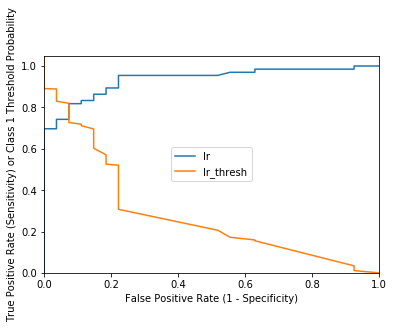

In [54]:
# plot LR and RF model ROC curves
sns.mpl.pyplot.plot(fpr_lr, tpr_lr,label="lr")
sns.mpl.pyplot.plot(fpr_lr,thresholds_lr, label="lr_thresh")
sns.mpl.pyplot.xlim([0, 1])
sns.mpl.pyplot.ylim([0, 1.05])
sns.mpl.pyplot.legend(loc="center")
sns.mpl.pyplot.xlabel('False Positive Rate (1 - Specificity)')
sns.mpl.pyplot.ylabel('True Positive Rate (Sensitivity) or Class 1 Threshold Probability')


It looks like the threshold that satisfies our criteria is ~0.7. Let's use this new threshold to generate our predictions and see what our new confusion matrix looks like:

In [55]:
y_test_lr_df["predicted_07"] = (y_test_lr_df.class_1 > 0.7).astype(float)
print(y_test_lr_df.head())
print("Confusion matrix at original 0.5 threshold:\n",metrics.confusion_matrix(y_test_lr_df.actual,
                                                                      y_test_lr_df.predicted),"\n")
print("Classification Report at original 0.5 threshold:\n", metrics.classification_report(y_test_lr_df.actual,
                                                                                          y_test_lr_df.predicted),"\n")
print("Confusion matrix at 0.7 threshold:\n",metrics.confusion_matrix(y_test_lr_df.actual,
                                                                      y_test_lr_df.predicted_07),"\n")
print("Classification Report at 0.7 threshold:\n", metrics.classification_report(y_test_lr_df.actual,
                                                                                 y_test_lr_df.predicted_07))

   class_0  class_1  predicted  actual  predicted_07
0    0.018    0.982        1.0     1.0           1.0
1    0.111    0.889        1.0     0.0           1.0
2    0.011    0.989        1.0     1.0           1.0
3    0.094    0.906        1.0     1.0           1.0
4    0.010    0.990        1.0     1.0           1.0
Confusion matrix at original 0.5 threshold:
 [[21  6]
 [ 6 60]] 

Classification Report at original 0.5 threshold:
               precision    recall  f1-score   support

         0.0       0.78      0.78      0.78        27
         1.0       0.91      0.91      0.91        66

   micro avg       0.87      0.87      0.87        93
   macro avg       0.84      0.84      0.84        93
weighted avg       0.87      0.87      0.87        93
 

Confusion matrix at 0.7 threshold:
 [[24  3]
 [11 55]] 

Classification Report at 0.7 threshold:
               precision    recall  f1-score   support

         0.0       0.69      0.89      0.77        27
         1.0       0.95      0

As a result, we've now increased our precision for class 1 (we are more certain someone has a back problem, when our classifier says you have a back problem), but have also lowered our recall for class 1 (now, more people with back problems will go un-identified by our classifier). The opposite occurs for precision and recall for class 0 as a result.

**So, depending on what you want to maximize or minimize for your machine learning application, your decision threshold for your (completely trained) classifier will differ.**

**One final important point about computing the AUC, you have to use the predicted probabilities, not the class labels themselves when computing an ROC curve or AUC.**

If you use y_pred_class, it will not give you an error, rather it will interpret the ones and zeros as predicted probabilities of 100% and 0%, and thus will give you incorrect results:

In [56]:
# calculate AUC using y_pred_class (producing incorrect results)
print("Wrong way to calculate LR model AUC: ",metrics.roc_auc_score(y_test, predictions_lr))
print("Wrong way to calculate RF model AUC: ",metrics.roc_auc_score(y_test, predictions_rf))

Wrong way to calculate LR model AUC:  0.8434343434343434
Wrong way to calculate RF model AUC:  0.8173400673400674


As a final way to compare the two models, let's see if we can look at each of their predicted probabilites on the test set as a function of the actual category (the target):

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d6efa90>,
      dtype=object)

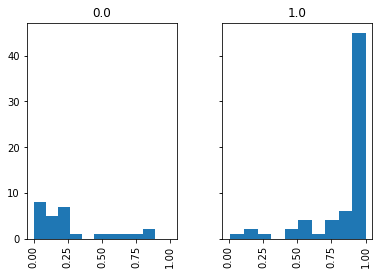

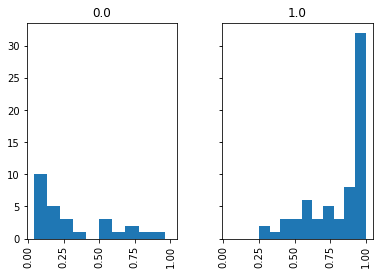

In [57]:
# histogram of predicted probabilities grouped by actual response value for LR
y_test_lr_df.class_1.hist(by= y_test_lr_df.actual, sharex=True, sharey=True)
#same for RF
y_test_rf_df.class_1.hist(by= y_test_rf_df.actual, sharex=True, sharey=True)

Depending on what threshold we choose will affect what part of each histogram consists of misclassified examples.

Nonetheless, it is fruitful at this point to examine all of those test-set samples that each classifier was "very certain" about (had very high or very low probability) but was of the wrong category (a class 0 sample that had a very high probability or a class 1 sample with a probability very close to 0).


### ROC/Confusion Matrix/Metric Takeaways

* For binary classifiers, you want to have the highest AUC possible. To decide between two classifiers, maximize the one that has the higher AUC.
* Once you've maximized your AUC, you set about choosing your classifier threshold based on the specifics of your problem. If you need to minimize false alarms (so maximize precision) while keeping your recall some acceptable level, then you do one thing. If you need to maximize accuracy, you do something else.
* In every case, what you're doing is generating a threshold from a specific point on the ROC curve.